In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [195]:
df = pd.read_csv('../data/processed/processed_abalone_data.csv')

In [196]:
correlations = df.drop(columns=['Age']).corrwith(df['Age'])
print(correlations)

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
dtype: float64


In [197]:
most_correlated_var = correlations.idxmax()
X = df[[most_correlated_var]]
y = df['Age']
model = LinearRegression().fit(X, y)

beta_0 = model.intercept_
beta_1 = model.coef_[0]
print(f'Intercept(beta_0): {beta_0}, Coefficient(beta_1): {beta_1}')

Intercept(beta_0): 7.983920159887557, Coefficient(beta_1): 14.58655012440063


In [198]:
import statsmodels.api as sm
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2713.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        05:43:21   Log-Likelihood:                -9770.8
No. Observations:                4177   AIC:                         1.955e+04
Df Residuals:                    4175   BIC:                         1.956e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.9839      0.077    103.978   

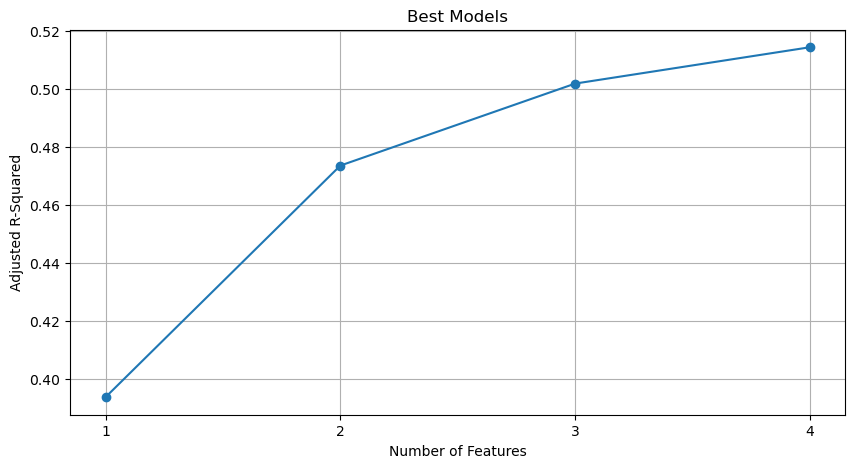

In [199]:
X = df.drop(columns=['Age'], axis=1)
y = df['Age']
results = []
def generate_combinations(X, current_index=0, current_combo=[]):
    if len(current_combo) > 0 and len(current_combo) <=4:
        X_combo = sm.add_constant(X[current_combo])
        model = sm.OLS(y, X_combo).fit()
        results.append((current_combo.copy(), model.rsquared_adj))
    if len(current_combo) == 4 or current_index == len(X.columns):
        return
    for i in range(current_index, len(X.columns)):
        current_combo.append(X.columns[i])
        generate_combinations(X, i+1, current_combo)
        current_combo.pop()
generate_combinations(X)
best_models = pd.DataFrame(results, columns=['Features', 'Adj_R2'])
best_models = best_models.groupby([len(c) for c in best_models['Features']]).apply(lambda x: x.nlargest(1, 'Adj_R2'))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 5), best_models['Adj_R2'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Adjusted R-Squared')
plt.title('Best Models')
plt.xticks(range(1, 5))
plt.grid(True)
plt.show()

In [200]:

results_df = pd.DataFrame(results, columns=['Features', 'Adj_R2'])


results_df['Num_Features'] = results_df['Features'].apply(len)

best_models = results_df.groupby('Num_Features').apply(lambda x: x.nlargest(1, 'Adj_R2'))

for index, row in best_models.iterrows():
    print(f"Number of features: {row['Num_Features']}, Features: {row['Features']}, Adjusted R²: {row['Adj_R2']}")


Number of features: 1, Features: ['Shell weight'], Adjusted R²: 0.3937039955182152
Number of features: 2, Features: ['Shucked weight', 'Shell weight'], Adjusted R²: 0.4736712665147663
Number of features: 3, Features: ['Diameter', 'Shucked weight', 'Shell weight'], Adjusted R²: 0.5019831423976622
Number of features: 4, Features: ['Diameter', 'Whole weight', 'Shucked weight', 'Shell weight'], Adjusted R²: 0.5145295283409048


/var/folders/6d/7kl6lflx0130f6swncnxzpjw0000gn/T/ipykernel_28191/872319994.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = results_df.groupby('Num_Features').apply(lambda x: x.nlargest(1, 'Adj_R2'))


In [201]:
model_selected = sm.OLS(y, sm.add_constant(X[best_models.Features.values[-1]])).fit()
model_selected.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1107.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        05:43:21   Log-Likelihood:                -9305.1
No. Observations:                4177   AIC:                         1.862e+04
Df Residuals:                    4172   BIC:                         1.865e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6445      0.197     28.623      0.000       5.258       6.031
Diameter           7.8360      0.563     13.929      0.000       6.733       8.939
Whole weight      17.1043      1.639     10.433      0.000      13.890      20.318
Shucked weight   -28.0951      1.191    -23.595      0.000     -30.430     -25.761
Shell weight      12.2808      1.083     11.338      0.000      10.157      14.404
==============================================================================
Omnibus:                     1013.254   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2840.204
Skew:                           1.271   Prob(JB):                         0.00
Kurtosis:                       6.140   Cond. No.                         78.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [202]:
df_with_sex = pd.read_csv('../data/raw/abalone_data.csv')
df_with_sex = df_with_sex['Sex']
df['Sex'] = df_with_sex
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age,Sex
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,16.5,M
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,8.5,M
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,10.5,F
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,11.5,M
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,8.5,I


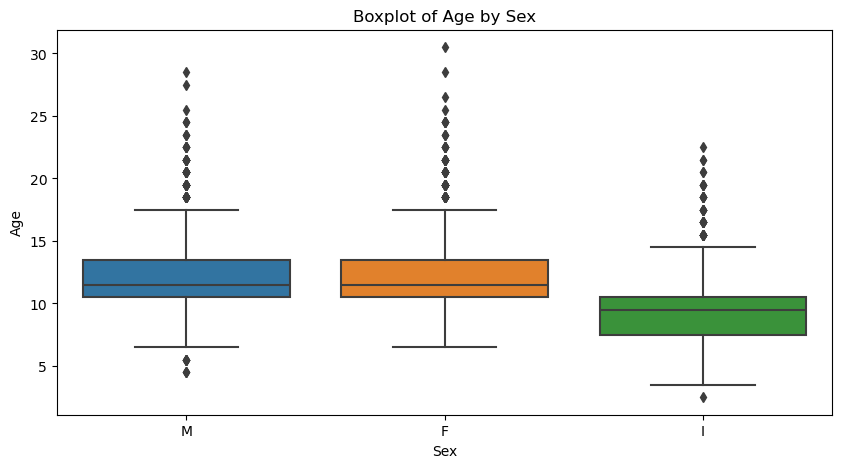

In [203]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Sex', y='Age', data=df)
plt.title('Boxplot of Age by Sex')
plt.show()

In [204]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=False)
df[['Sex_F', 'Sex_I', 'Sex_M']]=df[['Sex_F', 'Sex_I', 'Sex_M']].astype(int) ## turn the dummy variables into integers
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age,Sex_F,Sex_I,Sex_M
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,16.5,0,0,1
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,8.5,0,0,1
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,10.5,1,0,0
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,11.5,0,0,1
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,8.5,0,1,0


In [205]:
X = df[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']]
y = df['Age']
X = sm.add_constant(X)
model_with_sex = sm.OLS(y, X).fit()
print(model_with_sex.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     538.9
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        05:43:21   Log-Likelihood:                -9204.1
No. Observations:                4177   AIC:                         1.843e+04
Df Residuals:                    4167   BIC:                         1.849e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.2897      0.170     25.

In [208]:
test_value = pd.DataFrame({
    'Length': [0.5],  ## why infant abalone have 0.5 length???
    'Diameter': [0.4], ## ??
    'Height': [0.1], 
    'Whole weight':[0.4], 
    'Shucked weight': [0.15], 
    'Viscera weight': [0.08], 
    'Shell weight':[0.13], 
    'Sex_F': [0], 
    'Sex_I': [1],
    'Sex_M': [0]})
## test_value = sm.add_constant(test_value) dosen't work
test_value['const'] = 1.0

cols = test_value.columns.tolist()
cols = [cols[-1]] + cols[:-1]
test_value = test_value[cols]
test_value
model_with_sex.predict(test_value)


0    15.878594
dtype: float64